# Multiple Linear Regression Analysis for Fish Dataset

## Import necessary libraries

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')

## 1. DATA PREPROCESSING AND EXPLORATORY DATA ANALYSIS

   Category Species  Weight   Height   Width  Length1  Length2  Length3
0         1   Bream   242.0  11.5200  4.0200     23.2     25.4     30.0
1         1   Bream   290.0  12.4800  4.3056     24.0     26.3     31.2
2         1   Bream   340.0  12.3778  4.6961     23.9     26.5     31.1
3         1   Bream   363.0  12.7300  4.4555     26.3     29.0     33.5
4         1   Bream   430.0  12.4440  5.1340     26.5     29.0     34.0

Column names: Index(['Category', 'Species', 'Weight', 'Height', 'Width', 'Length1',
       'Length2', 'Length3'],
      dtype='object')

Missing values per column:
Category    0
Species     0
Weight      0
Height      0
Width       0
Length1     0
Length2     0
Length3     0
dtype: int64

Summary Statistics:
--------------------------------------------------
         Category       Weight      Height       Width     Length1  \
count  159.000000   159.000000  159.000000  159.000000  159.000000   
mean     3.264151   398.326415    8.970994    4.417486   26.247170

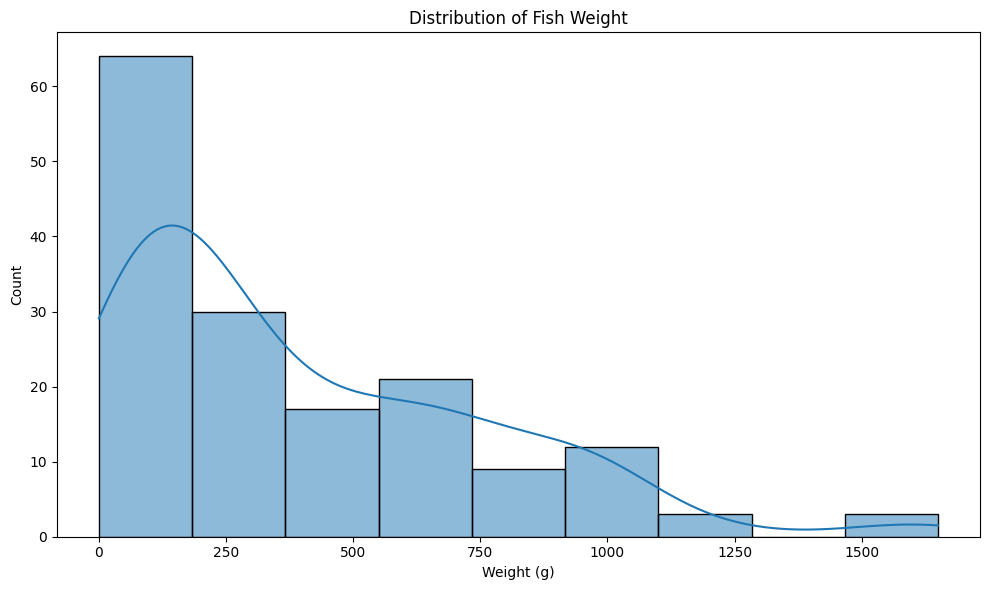

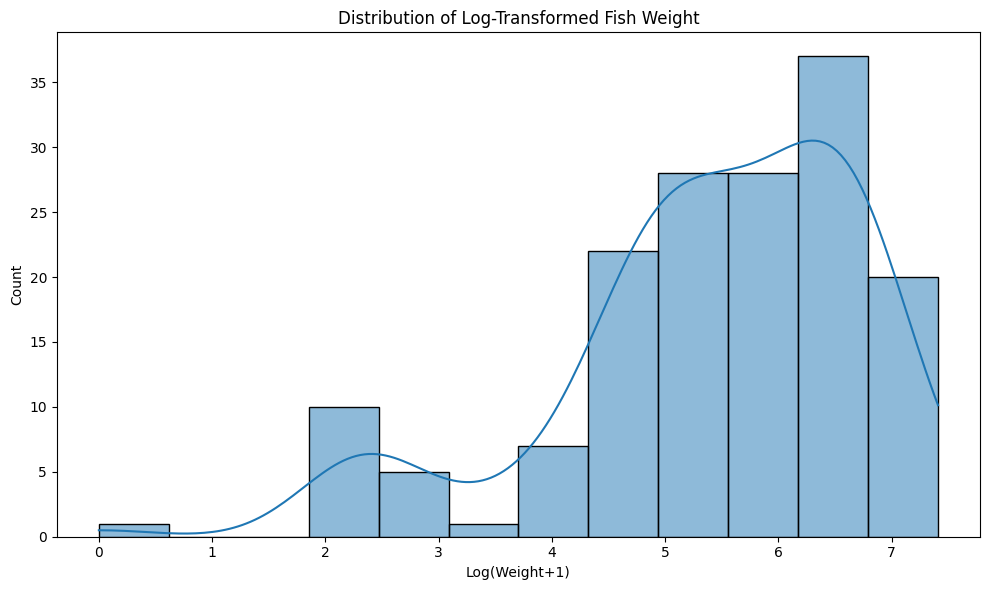

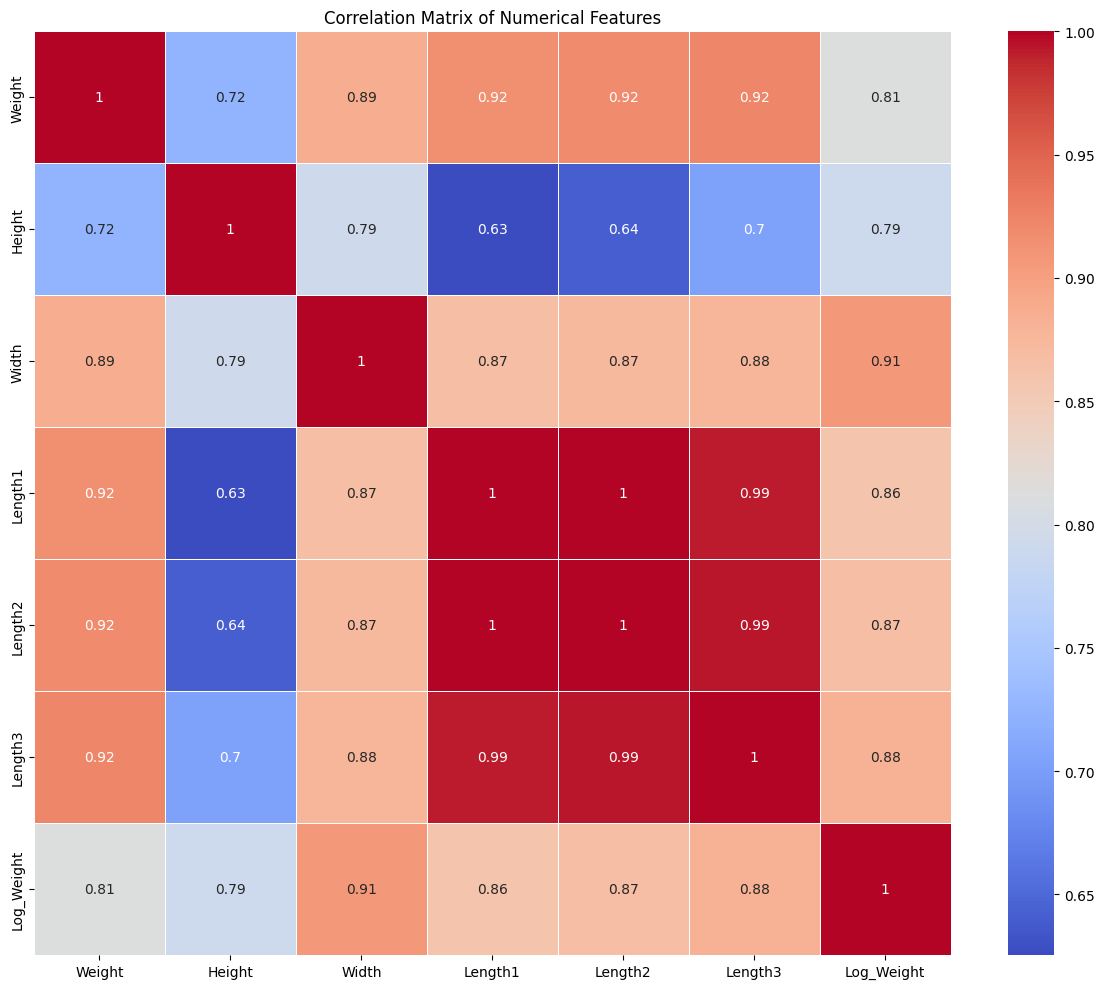

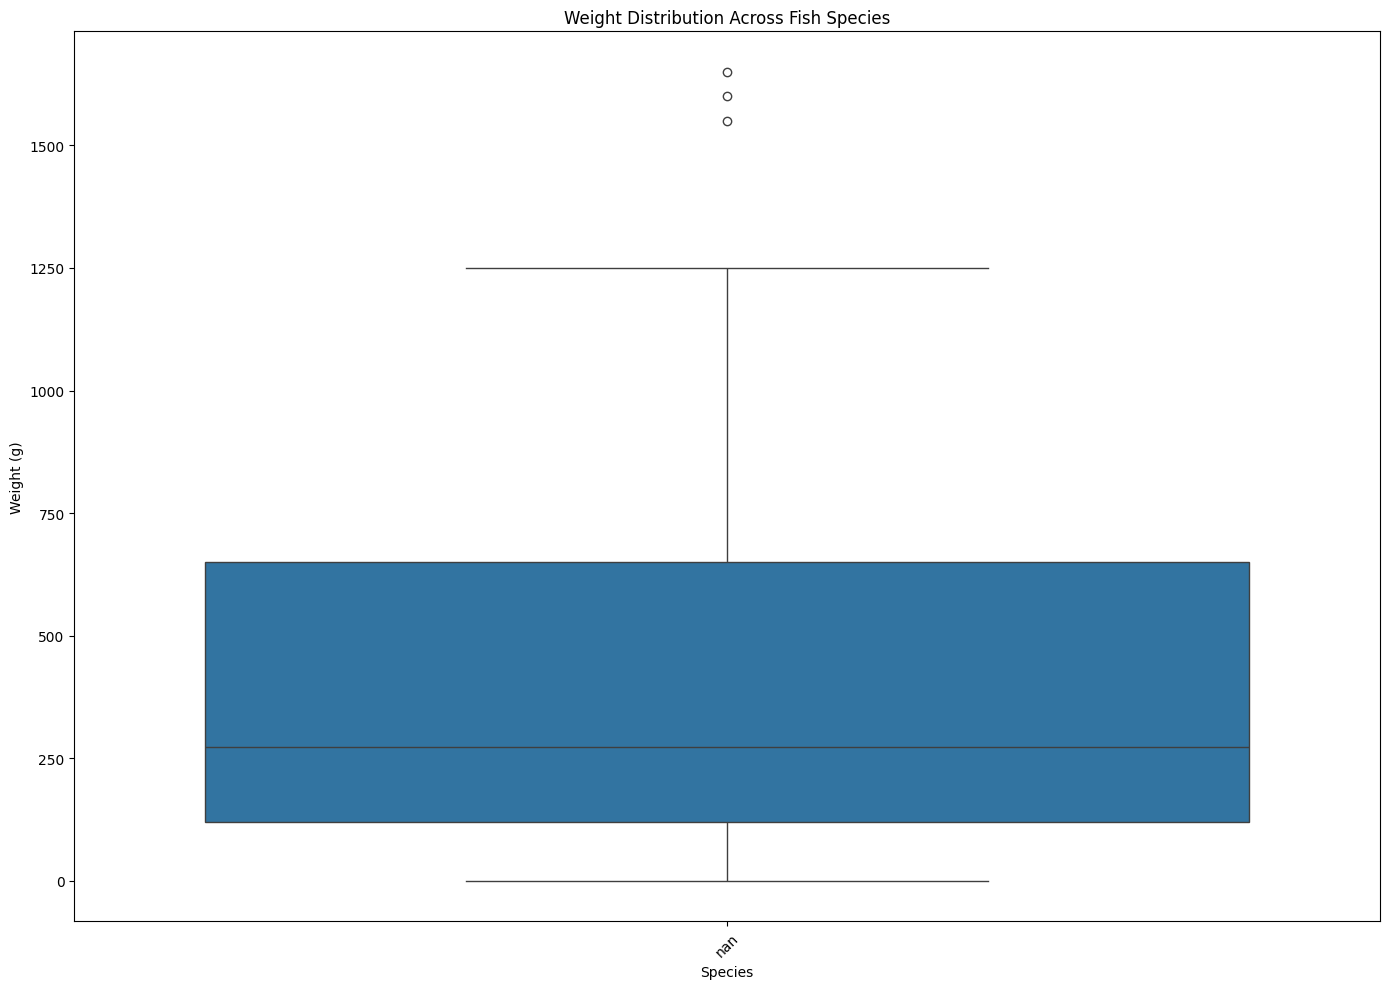

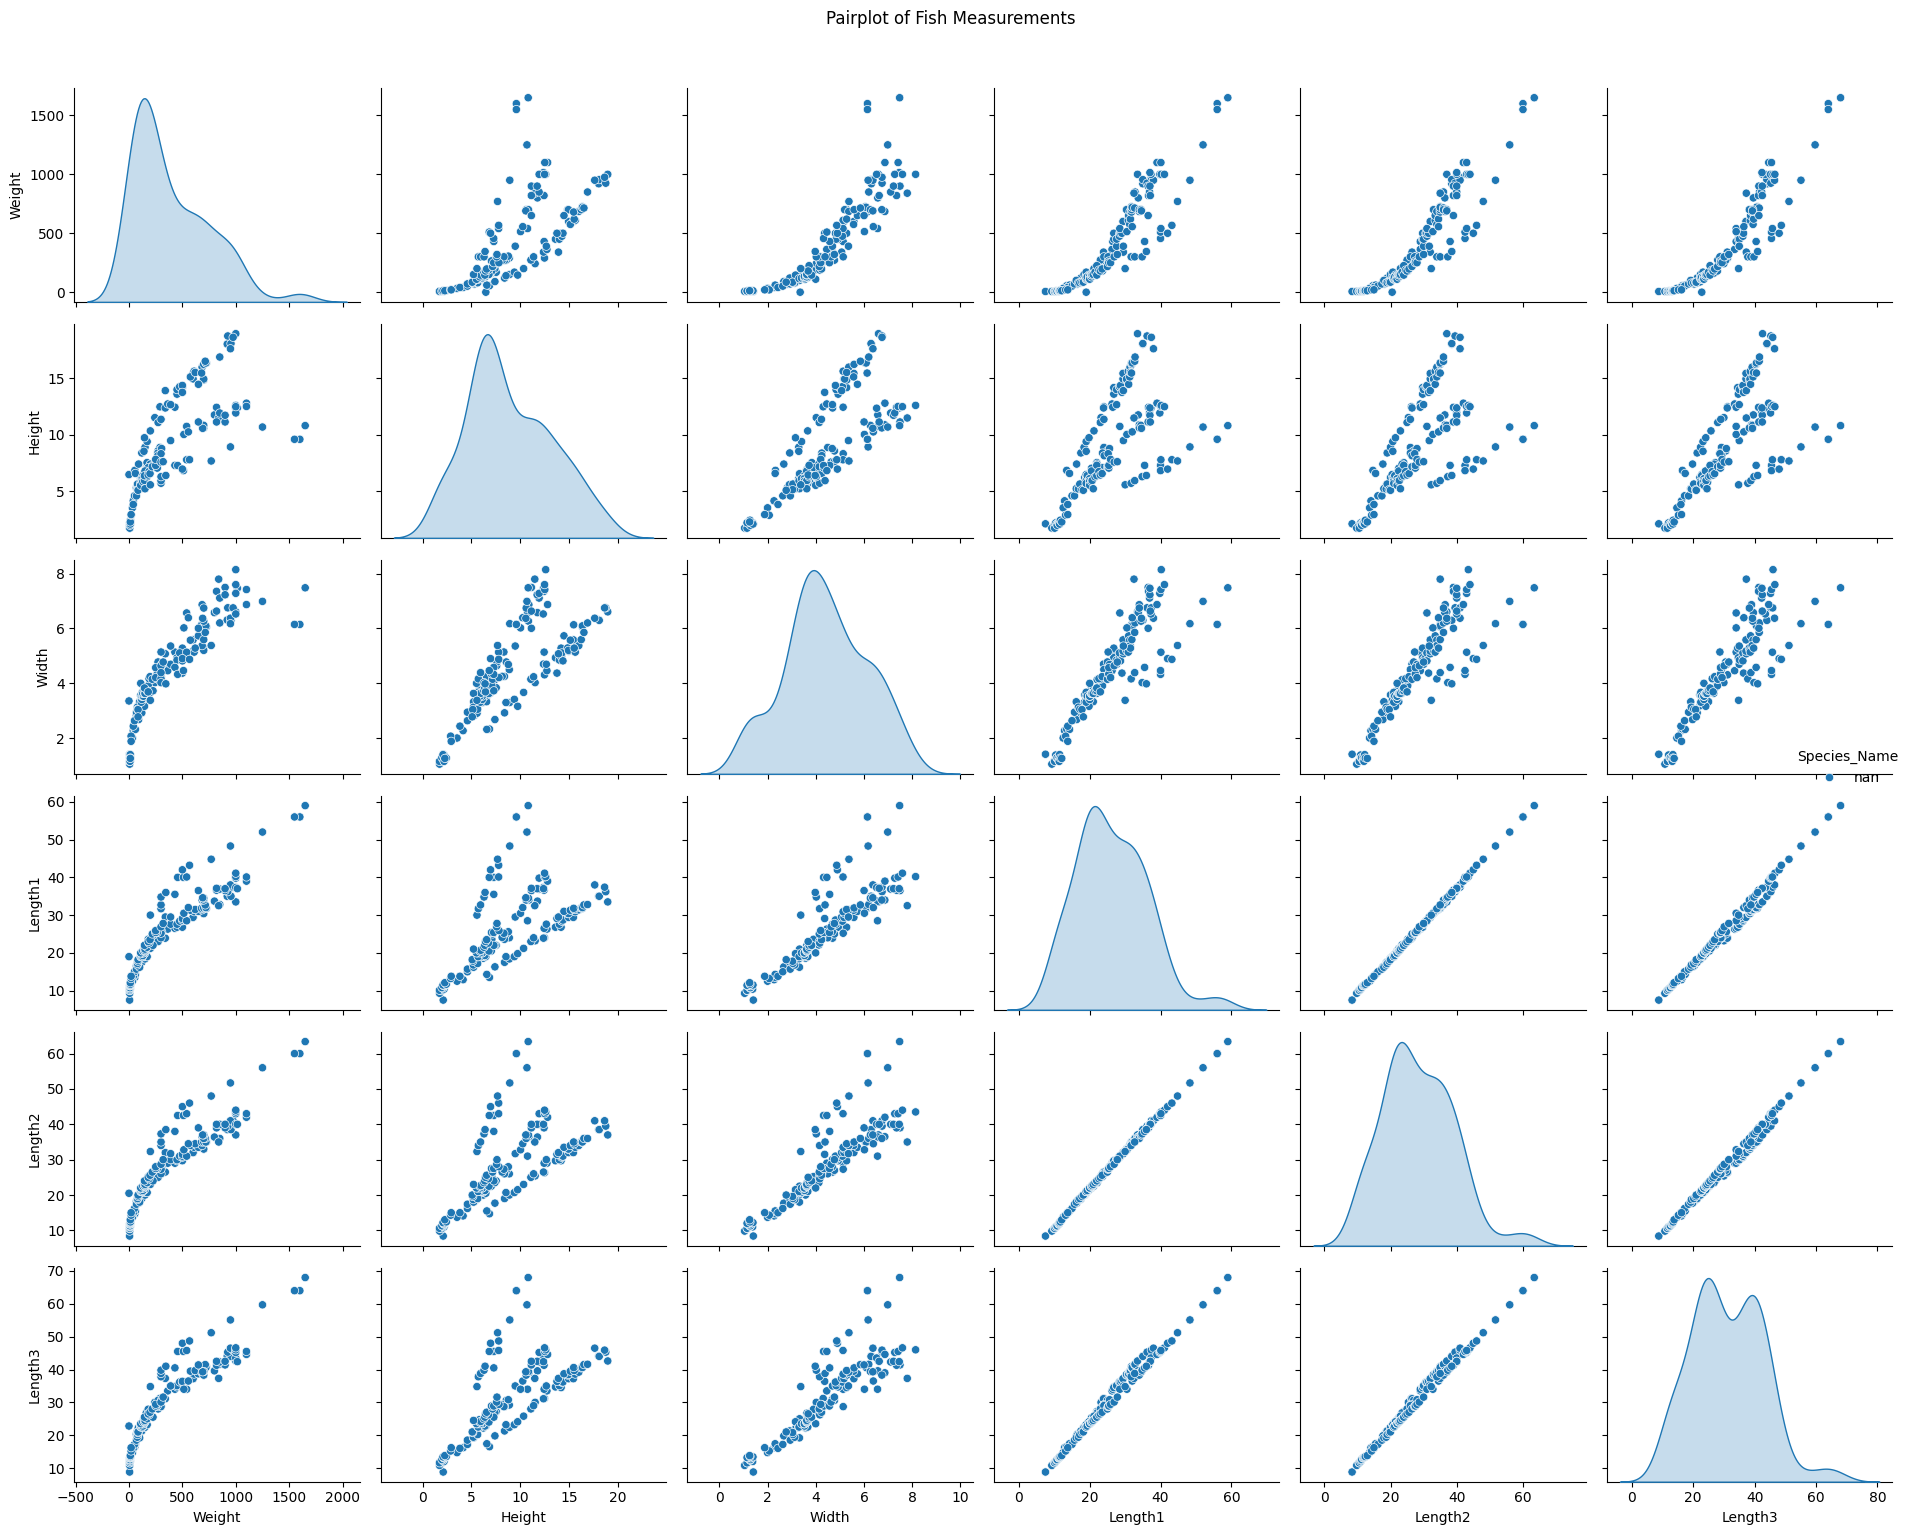

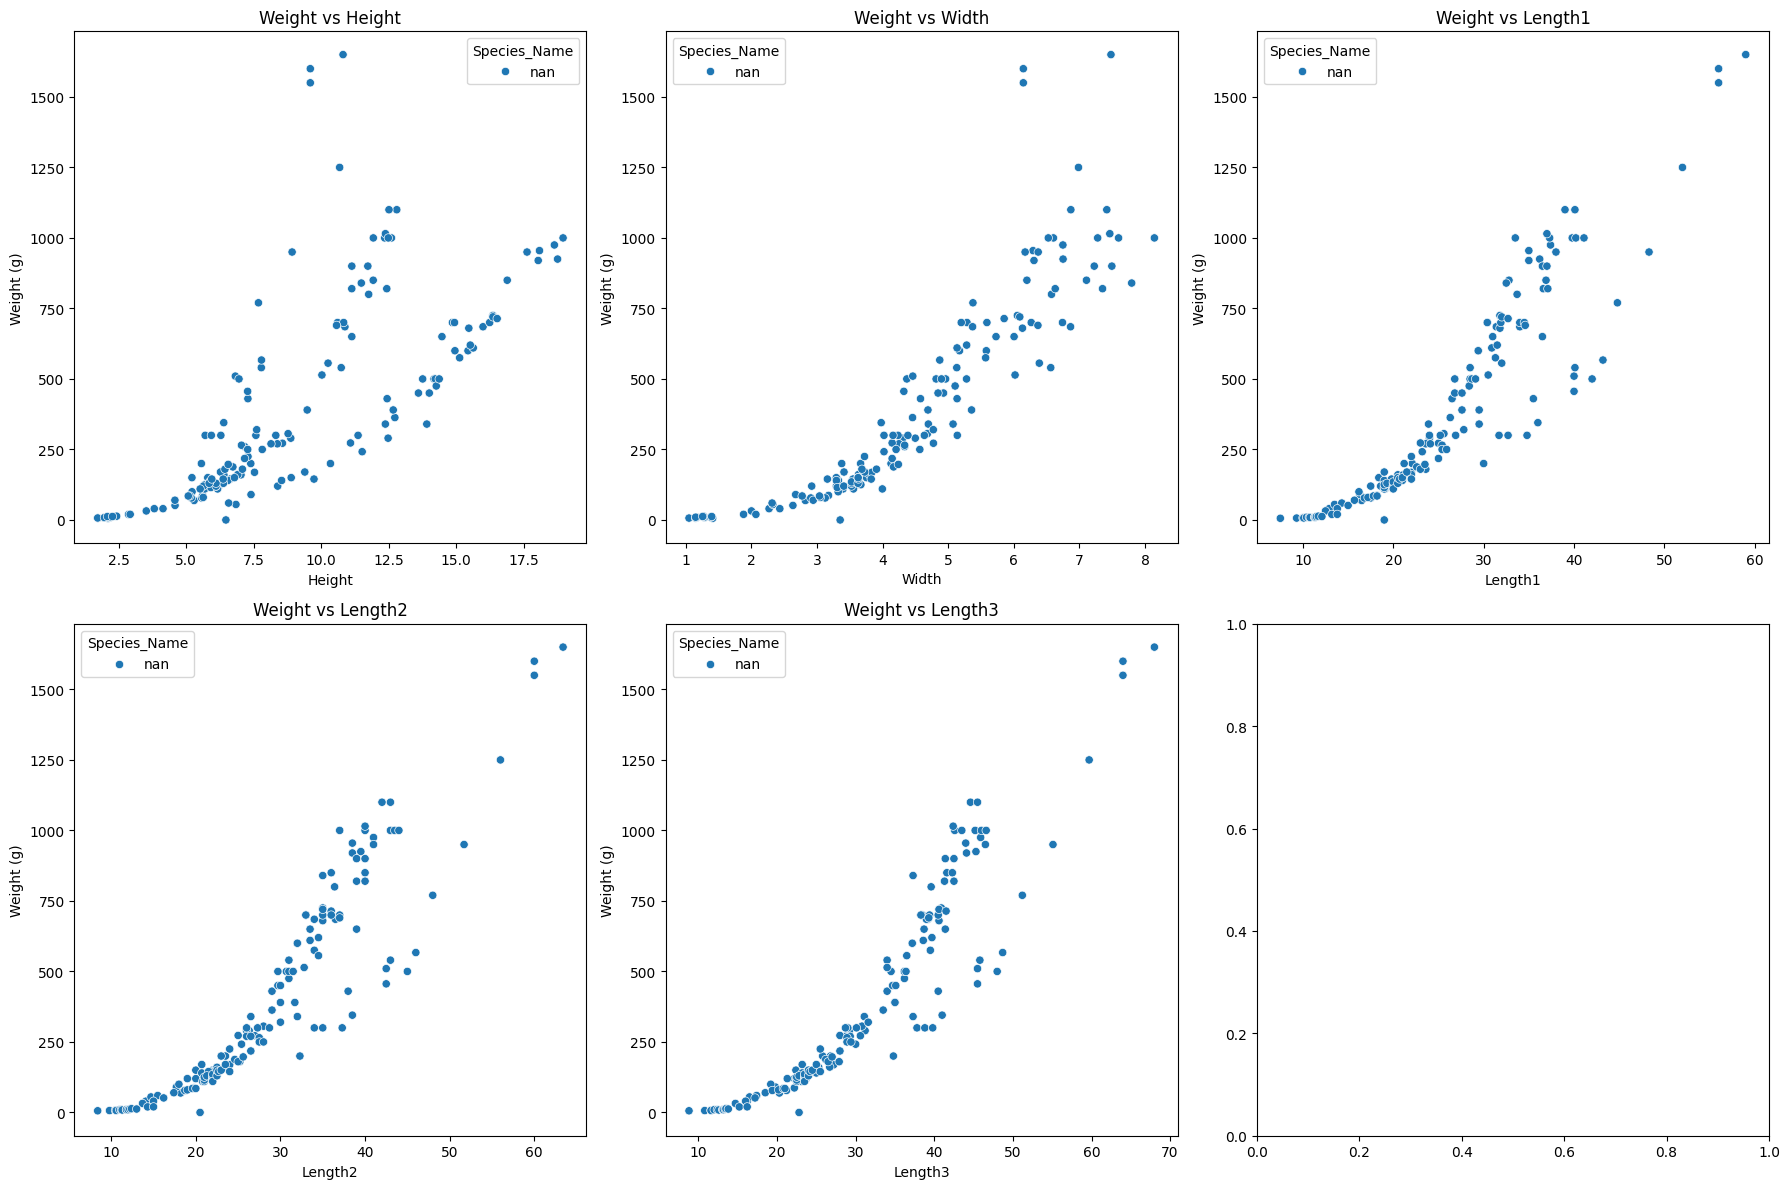

In [25]:
# Load the data
df = pd.read_csv(r"C:\Users\sonam\Downloads\Fish.csv")
print(df.head())
print("\nColumn names:", df.columns)

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Replace missing values if any
if df.isnull().sum().sum() > 0:
    # Replace numerical missing values with median
    for col in df.select_dtypes(include=['float64', 'int64']).columns:
        if df[col].isnull().sum() > 0:
            df[col].fillna(df[col].median(), inplace=True)

# Summary statistics
print("\nSummary Statistics:")
print("-" * 50)
print(df.describe())

# Convert Category to categorical type for better visualization
df['Category'] = df['Category'].astype('category')
species_mapping = {
    1: 'Bream',
    2: 'Parkki',
    3: 'Perch',
    4: 'Pike',
    5: 'Roach',
    6: 'Smelt',
    7: 'Whitefish'
}
df['Species_Name'] = df['Species'].map(species_mapping)

# Ensure Species_Name and Weight columns are valid
df['Species_Name'] = df['Species_Name'].astype(str)  # Convert to string for categorical plotting
df['Weight'] = pd.to_numeric(df['Weight'], errors='coerce')  # Convert to numeric
df = df.dropna(subset=['Species_Name', 'Weight'])  # Drop rows with missing values in these columns

# Exploratory Data Analysis (EDA)


# Distribution of Weight (target variable)
plt.figure(figsize=(10, 6))
sns.histplot(df['Weight'], kde=True)
plt.title('Distribution of Fish Weight')
plt.xlabel('Weight (g)')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('weight_distribution.png')
plt.show()
plt.close()

# Log transformation of Weight (since it might be skewed)
df['Log_Weight'] = np.log1p(df['Weight'])
plt.figure(figsize=(10, 6))
sns.histplot(df['Log_Weight'], kde=True)
plt.title('Distribution of Log-Transformed Fish Weight')
plt.xlabel('Log(Weight+1)')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('log_weight_distribution.png')
plt.show()
plt.close()

# Correlation matrix of numerical features
plt.figure(figsize=(12, 10))
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = df[numerical_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.savefig('correlation_matrix.png')
plt.show()
plt.close()

# Box plots to identify outliers and compare distributions across species
plt.figure(figsize=(14, 10))
sns.boxplot(x='Species_Name', y='Weight', data=df)
plt.title('Weight Distribution Across Fish Species')
plt.xlabel('Species')
plt.ylabel('Weight (g)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('weight_by_species.png')
plt.show()
plt.close()

# Pairplot for key measurements
sns.pairplot(df[['Weight', 'Height', 'Width', 'Length1', 'Length2', 'Length3', 'Species_Name']], 
             hue='Species_Name', height=2.5, aspect=1.2)
plt.suptitle('Pairplot of Fish Measurements', y=1.02)
plt.tight_layout()
plt.savefig('pairplot.png')
plt.show()
plt.close()

# Analyze relationships with scatter plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, col in enumerate(['Height', 'Width', 'Length1', 'Length2', 'Length3']):
    sns.scatterplot(x=col, y='Weight', hue='Species_Name', data=df, ax=axes[i])
    axes[i].set_title(f'Weight vs {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Weight (g)')

plt.tight_layout()
plt.savefig('weight_vs_measurements.png')
plt.show()
plt.close()


## 2. FEATURE SELECTION/EXTRACTION

In [22]:
print("\nFeature Selection Analysis:")
print("-" * 50)

# Prepare data for feature selection
X = df.drop(['Weight', 'Species_Name', 'Log_Weight', 'Species'], axis=1)
y = df['Weight']

# 1. Correlation-based feature selection
correlation_with_target = X.corrwith(y).abs().sort_values(ascending=False)
print("Correlation of features with target (Weight):")
print(correlation_with_target)

# 2. Variance Inflation Factor (VIF) for multicollinearity
X_with_const = sm.add_constant(X)
vif_data = pd.DataFrame()
vif_data["Feature"] = X_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]
print("\nVariance Inflation Factor (VIF) for multicollinearity:")
print(vif_data.sort_values('VIF', ascending=False))

# 3. Feature selection using SelectKBest (f_regression)
selector = SelectKBest(f_regression, k=4)
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]
print("\nTop features selected by f_regression:")
print(selected_features.tolist())

# 4. Recursive Feature Elimination (RFE)
rfe = RFE(estimator=LinearRegression(), n_features_to_select=4)
X_rfe = rfe.fit_transform(X, y)
selected_features_rfe = X.columns[rfe.support_]
print("\nFeatures selected by Recursive Feature Elimination:")
print(selected_features_rfe.tolist())

# Based on the feature selection analysis, select the best features
# We'll use the SelectKBest method which is well-suited for linear regression
selected_features_final = selected_features.tolist()
print("\nFinal selected features for modeling:")
print(selected_features_final)


Feature Selection Analysis:
--------------------------------------------------
Correlation of features with target (Weight):
Length3     0.923044
Length2     0.918618
Length1     0.915712
Width       0.886507
Height      0.724345
Category    0.312960
dtype: float64

Variance Inflation Factor (VIF) for multicollinearity:
    Feature          VIF
5   Length2  2394.764182
4   Length1  1785.401152
6   Length3   477.116405
0     const    32.397195
2    Height    21.319411
3     Width    14.432480
1  Category     2.685429

Top features selected by f_regression:
['Width', 'Length1', 'Length2', 'Length3']

Features selected by Recursive Feature Elimination:
['Category', 'Height', 'Length2', 'Length3']

Final selected features for modeling:
['Width', 'Length1', 'Length2', 'Length3']


## 3. MODEL DEVELOPMENT AND TUNING

In [23]:
# Split the data into training and testing sets
X_selected = df[selected_features_final]
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.25, random_state=42)

print("\nModel Development:")
print("-" * 50)
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

# A. Multiple Linear Regression (Baseline Model)
# -------------------------------------------
print("\nTraining Multiple Linear Regression (Baseline Model)...")
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Metrics for linear regression
y_pred_linear = linear_model.predict(X_test)
mse_linear = mean_squared_error(y_test, y_pred_linear)
rmse_linear = np.sqrt(mse_linear)
r2_linear = r2_score(y_test, y_pred_linear)
mae_linear = mean_absolute_error(y_test, y_pred_linear)

print("\nMultiple Linear Regression Results:")
print(f"Mean Squared Error: {mse_linear:.2f}")
print(f"Root Mean Squared Error: {rmse_linear:.2f}")
print(f"R² Score: {r2_linear:.4f}")
print(f"Mean Absolute Error: {mae_linear:.2f}")

# Get coefficients
coefficients = pd.DataFrame({
    'Feature': X_selected.columns,
    'Coefficient': linear_model.coef_
}).sort_values('Coefficient', ascending=False)
print("\nLinear Regression Coefficients:")
print(coefficients)

# B. Ridge Regression with hyperparameter tuning
# ---------------------------------------------
print("\nTraining Ridge Regression with hyperparameter tuning...")
ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Ridge needs scaling
    ('model', Ridge())
])

# Define a range of alpha values to try
ridge_params = {
    'model__alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
}

# Perform grid search with cross-validation
ridge_grid = GridSearchCV(ridge_pipeline, ridge_params, cv=5, scoring='neg_mean_squared_error', verbose=1)
ridge_grid.fit(X_train, y_train)

# Best Ridge model
best_ridge = ridge_grid.best_estimator_
y_pred_ridge = best_ridge.predict(X_test)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mse_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)

print("\nRidge Regression Results:")
print(f"Best alpha: {ridge_grid.best_params_['model__alpha']}")
print(f"Cross-validation score: {-ridge_grid.best_score_:.2f} (MSE)")
print(f"Mean Squared Error: {mse_ridge:.2f}")
print(f"Root Mean Squared Error: {rmse_ridge:.2f}")
print(f"R² Score: {r2_ridge:.4f}")
print(f"Mean Absolute Error: {mae_ridge:.2f}")

# Get Ridge coefficients
ridge_coefficients = pd.DataFrame({
    'Feature': X_selected.columns,
    'Coefficient': best_ridge.named_steps['model'].coef_
}).sort_values('Coefficient', ascending=False)
print("\nRidge Regression Coefficients:")
print(ridge_coefficients)


Model Development:
--------------------------------------------------
Training set size: 119 samples
Testing set size: 40 samples

Training Multiple Linear Regression (Baseline Model)...

Multiple Linear Regression Results:
Mean Squared Error: 16904.75
Root Mean Squared Error: 130.02
R² Score: 0.8703
Mean Absolute Error: 102.29

Linear Regression Coefficients:
   Feature  Coefficient
0    Width    63.360981
3  Length3    11.794363
1  Length1     7.809564
2  Length2     2.386182

Training Ridge Regression with hyperparameter tuning...
Fitting 5 folds for each of 7 candidates, totalling 35 fits

Ridge Regression Results:
Best alpha: 10.0
Cross-validation score: 16502.44 (MSE)
Mean Squared Error: 17434.25
Root Mean Squared Error: 132.04
R² Score: 0.8663
Mean Absolute Error: 105.43

Ridge Regression Coefficients:
   Feature  Coefficient
0    Width    96.090665
3  Length3    85.033256
2  Length2    77.717314
1  Length1    76.335345


## 4. MODEL EVALUATION AND COMPARISON


Model Comparison:
--------------------------------------------------
                        Model           MSE        RMSE        R²         MAE
0  Multiple Linear Regression  16904.753242  130.018280  0.870350  102.289490
1            Ridge Regression  17434.253264  132.038832  0.866289  105.431547


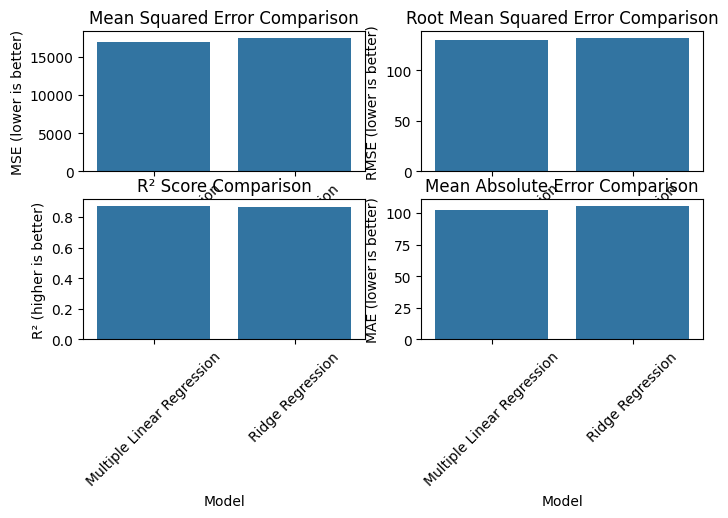

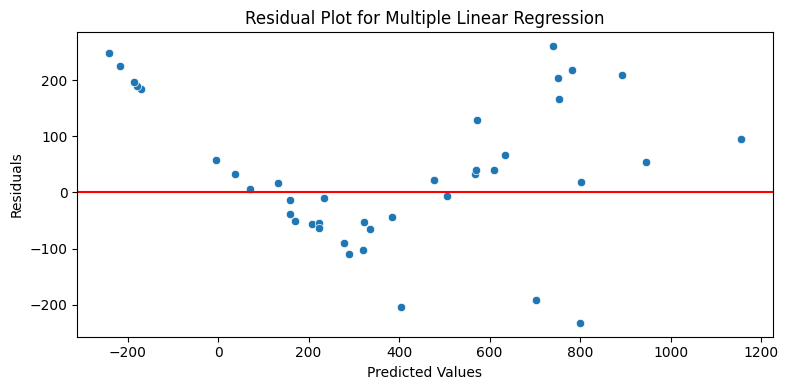

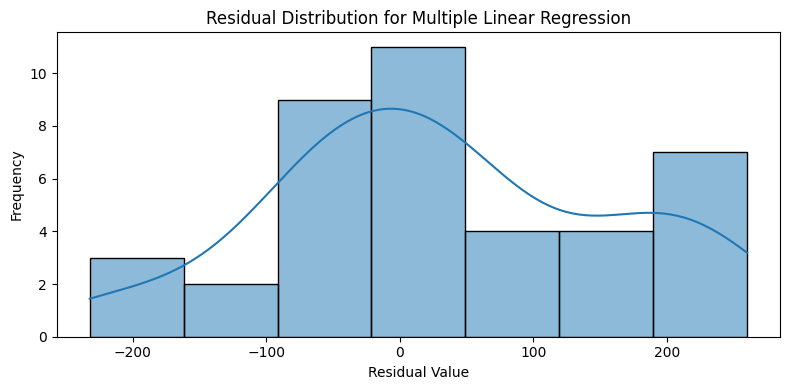

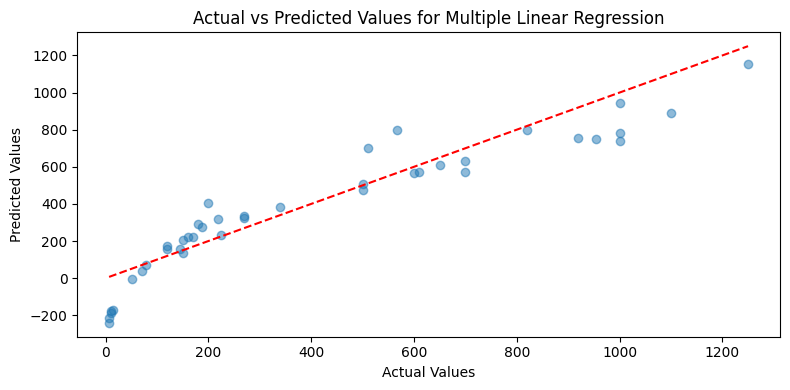

In [24]:
# Create a dataframe to compare the models
models = ['Multiple Linear Regression', 'Ridge Regression']
mse_values = [mse_linear, mse_ridge]
rmse_values = [rmse_linear, rmse_ridge]
r2_values = [r2_linear, r2_ridge]
mae_values = [mae_linear, mae_ridge]

model_comparison = pd.DataFrame({
    'Model': models,
    'MSE': mse_values,
    'RMSE': rmse_values,
    'R²': r2_values,
    'MAE': mae_values
})

print("\nModel Comparison:")
print("-" * 50)
print(model_comparison.sort_values('MSE'))

# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(8, 4))

# MSE comparison
sns.barplot(x='Model', y='MSE', data=model_comparison, ax=axes[0, 0])
axes[0, 0].set_title('Mean Squared Error Comparison')
axes[0, 0].set_ylabel('MSE (lower is better)')
axes[0, 0].tick_params(axis='x', rotation=45)

# RMSE comparison
sns.barplot(x='Model', y='RMSE', data=model_comparison, ax=axes[0, 1])
axes[0, 1].set_title('Root Mean Squared Error Comparison')
axes[0, 1].set_ylabel('RMSE (lower is better)')
axes[0, 1].tick_params(axis='x', rotation=45)

# R² comparison
sns.barplot(x='Model', y='R²', data=model_comparison, ax=axes[1, 0])
axes[1, 0].set_title('R² Score Comparison')
axes[1, 0].set_ylabel('R² (higher is better)')
axes[1, 0].tick_params(axis='x', rotation=45)

# MAE comparison
sns.barplot(x='Model', y='MAE', data=model_comparison, ax=axes[1, 1])
axes[1, 1].set_title('Mean Absolute Error Comparison')
axes[1, 1].set_ylabel('MAE (lower is better)')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('model_comparison.png')
plt.show()  # Force the plot to show
plt.close()

# Residual analysis for the best model
residuals = y_test - y_pred_best
plt.figure(figsize=(8, 4))
sns.scatterplot(x=y_pred_best, y=residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.title(f'Residual Plot for {best_model_name}')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.tight_layout()
plt.savefig('residual_plot.png')
plt.show()
plt.close()

# Residual distribution
plt.figure(figsize=(8, 4))
sns.histplot(residuals, kde=True)
plt.title(f'Residual Distribution for {best_model_name}')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('residual_distribution.png')
plt.show()
plt.close()

# Predicted vs Actual plot
plt.figure(figsize=(8, 4))
plt.scatter(y_test, y_pred_best, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title(f'Actual vs Predicted Values for {best_model_name}')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.tight_layout()
plt.savefig('actual_vs_predicted.png')
plt.show()
plt.close()
